# Tutorial: Generate features
This tutorial demonstrates how to generate features to represent game states to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.

This tutorial demonstrates the following three steps:
   1. Investigate the data in SPADL representation.
   2. Construct features to represent actions.
   3. Construct features to represent game states.

This notebook is compatible with `socceraction` version `0.2.0`.

**Conventions:**
   * Variables that refer a `DataFrame` object are prefixed with `df_`.
   * Variables that refer a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.
   
**References:**
   * Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
   * Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. \"[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)\" *Scientific Data 6*, no. 1 (2019): 1-15."

**Optional:** If you run this notebook on Google Colab, then uncomment the code in the following cell and execute the cell.

In [5]:
!pip install tables==3.6.1
!pip install matplotsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
  Preparing metadata (setup.py) ... done
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5966 sha256=5ccb0e65a29ccb8b43ebcd53c732c1395d6c7d18af7fbf3d13070cee1adae137
  Stored in directory: /root/.cache/pip/wheels/ef/a9/d2/796b0ad28ffe440216ddaf7c9aa570dbdbfd67c3b208fd07ca
Successfully built matplotsoccer


**Optional:** If you run this notebook on Google Colab and wish to store all data in a Google Drive folder, then uncomment the code in the following cell and execute the cell.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %mkdir -p '/content/gdrive/My Drive/Friends of Tracking/'
# %cd '/content/gdrive/My Drive/Friends of Tracking/'

In [6]:
import warnings
import matplotsoccer
import numpy as np
import pandas as pd
from ipywidgets import fixed, interact_manual, widgets
from tqdm.notebook import tqdm

In [ ]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Load dataset

First we load the SPADL dataset that was created in the tutorial1-run-pipeline.ipynb notebook. We first load the teams, players and games dataframes.

In [7]:
df_teams = pd.read_hdf('/spadl.h5', key='teams')
df_players = pd.read_hdf('/spadl.h5', key='players')
df_games = pd.read_hdf('/spadl.h5', key='games')

We add the team names to the df_games dataframe such that we know which two teams played in which match.

In [8]:
team_name_mapping = df_teams.set_index('team_id')['team_name'].to_dict()
df_games['home_team_name'] = df_games['home_team_id'].map(team_name_mapping)
df_games['away_team_name'] = df_games['away_team_id'].map(team_name_mapping)

# Explore SPADL actions

In this secion we will explore the SPADL actions for a selected match. In this notebook we chose the World Cup 2018 match between Belgium and Japan. The notebook can also be run for a match of your choice.

In [10]:
df_games[(df_games['home_team_name'] == 'Belgium') &
         (df_games['away_team_name'] == 'Japan')]

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id,home_team_name,away_team_name
10,2058007,28,10078,2018-07-02 18:00:00,5629,12913,Belgium,Japan


**Note:** This notebook expects the data for the World Cup 2018 to be in the SPADL dataset. Make sure that the `game_id` selected in the cell below belongs to a game in your dataset.

In [11]:
# Select a game of choice
game_id = 2058007

## Load SPADL actions for selected game

For each action, the dataset contains the following information for the action:

* game_id: a unique identifier of the game;
* team_id: a unique identifier of the team who performed the action;
* player_id: a unique identifier of the player who performed the action;
* period: 1 for the first half and 2 for the second half;
* seconds: the time elapsed in seconds since the start of the half;
* type_id: the identifier for the type of action;
* type_name: the name for the type of action;
* body_part_id: 0 for foot, 1 for head, 2 for other body part;
* result: the result of the action: 0 for failure, 1 for success;
* start_x: the x coordinate for the location where the action started, ranges from 0 to 105;
* start_y: the y coordinate for the location where the action started, ranges from 0 to 68;
* end_x: the x coordinate for the location where the action ended, ranges from 0 to 105;
* end_y: the y coordinate for the location where the action ended, ranges from 0 to 68.

The action types are:

    0: pass
    1: cross
    2: throw in
    3: freekick crossed
    4: freekick short
    5: corner crossed
    6: corner short
    7: take on
    8: foul
    9: tackle
    10: interception
    11: shot
    12: shot penalty
    13: shot freekick
    14: keeper save
    18: clearance
    21: dribble
    22: goalkick

We first load the actions for the selected game_id.

In [93]:
global_df_actions = None
for game_id in df_games['game_id'].head(10):
  with pd.HDFStore('/spadl.h5') as spadlstore:
    df_actions = spadlstore[f'actions/game_{game_id}']
    df_actions = (
        df_actions.merge(spadlstore['actiontypes'], how='left')
        .merge(spadlstore['results'], how='left')
        .merge(spadlstore['bodyparts'], how='left')
        .merge(spadlstore['players'], how="left")
        .merge(spadlstore['teams'], how='left')
        .reset_index()
        .rename(columns={'index': 'action_id'})
    )
    if global_df_actions is None:
      global_df_actions = df_actions
    else:
      global_df_actions = global_df_actions.append(df_actions)

<ipython-input-93-3d0115b12912>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  global_df_actions = global_df_actions.append(df_actions)
<ipython-input-93-3d0115b12912>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  global_df_actions = global_df_actions.append(df_actions)
<ipython-input-93-3d0115b12912>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  global_df_actions = global_df_actions.append(df_actions)
<ipython-input-93-3d0115b12912>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  global_df_actions = global_df_actions.append(df_actions)
<ipython-input-93-3d0115b12912>:17: FutureWarning: The frame.append method is deprecated

In [94]:
# Look at first 5 actions of the match
global_df_actions

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name
0,0,2565922.0,1.0,1.005442,687.0,3576.0,53.55,34.68,66.15,17.68,...,1,pass,success,foot,Juanmi,Juan Miguel,Jiménez López,1993-05-20,Real Sociedad,Real Sociedad de Fútbol
1,1,2565922.0,1.0,4.151517,687.0,3828.0,66.15,17.68,30.45,62.56,...,1,pass,success,foot,Raúl Navas,Raúl,Rodríguez Navas,1988-05-11,Real Sociedad,Real Sociedad de Fútbol
2,2,2565922.0,1.0,7.390181,687.0,261127.0,30.45,62.56,21.00,68.00,...,1,pass,success,foot,A. Januzaj,Adnan,Januzaj,1995-02-05,Real Sociedad,Real Sociedad de Fútbol
3,3,2565922.0,1.0,23.291657,676.0,3269.0,22.05,68.00,31.50,65.96,...,1,throw_in,success,other,Jordi Alba,Jordi,Alba Ramos,1989-03-21,Barcelona,FC Barcelona
4,4,2565922.0,1.0,24.254552,676.0,7972.0,30.45,66.64,33.60,66.64,...,0,pass,fail,foot,L. Suárez,Luis Alberto,Suárez Díaz,1987-01-24,Barcelona,FC Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,1258,2565918.0,2.0,2655.962868,695.0,237269.0,76.65,23.80,99.75,25.16,...,1,pass,success,foot,S. Lukić,Saša,Lukić,1996-08-13,Levante,Levante UD
1259,1259,2565918.0,2.0,2658.838006,695.0,278316.0,99.75,25.16,67.20,48.28,...,0,pass,fail,foot,Koke,Jorge,Ruiz Ojeda,1995-09-27,Levante,Levante UD
1260,1260,2565918.0,2.0,2661.507850,692.0,293856.0,67.20,48.28,87.15,59.16,...,1,pass,success,head,Dani Molina,Daniel,Molina Orta,1996-03-14,Celta de Vigo,Real Club Celta de Vigo
1261,1261,2565918.0,2.0,2669.145892,695.0,278049.0,88.20,56.44,88.20,56.44,...,1,foul,success,foot,E. Cabaco,Erick Cathriel,Cabaco Almada,1995-04-19,Levante,Levante UD


The following cells define some functions to make it more convenient to explore the actions.

In [54]:
def nice_time(row):
    minute = int((row['period_id']>=2) * 45 + (row['period_id']>=3) * 15 +
                 (row['period_id']==4) * 15 + row['time_seconds'] // 60)
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

df_actions['nice_time'] = df_actions.apply(nice_time,axis=1)

In [55]:
def action_name(row):
    return f"{row['action_id']}: {row['nice_time']} - {row['short_name']} {row['type_name']}"

df_actions['action_name'] = df_actions.apply(action_name, axis=1)

In [48]:
def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_name'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'short_name', 'short_team_name']],
        labeltitle=['time', 'actiontype', 'player', 'team'],
        zoom=False,
        figsize=8)

In [56]:
def plot_actions_from_action_name(df_actions, action_name):
    action_id = int(action_name.split(':')[0])
    df_actions_to_plot = df_actions[action_id-3: action_id+3]
    plot_actions(df_actions_to_plot)

In [96]:
df_actions = global_df_actions
shot_in_next_10_actions = []
# Iterate through each row in the DataFrame
for index, row in df_actions.iterrows():
    # Get the current action ID
    current_action = row['action_id']
    game_id = row['game_id']

    # Check if there is a shot in the next 10 actions
    shot_next_10_act = any((df_actions['action_id'] > current_action) & (df_actions['action_id'] <= current_action + 10) & (df_actions['type_name'] == 'shot') & (df_actions['game_id'] == game_id))

    # Append the result to the list
    shot_in_next_10_actions.append(shot_next_10_act)

# Add the boolean column to the DataFrame
df_actions['shot_in_next_10_actions'] = shot_in_next_10_actions

In [97]:
df_actions[df_actions['shot_in_next_10_actions']]

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name,shot_in_next_10_actions
28,28,2565922.0,1.0,90.477903,676.0,256634.0,24.15,50.32,40.95,64.60,...,pass,success,foot,Y. Mina,Yerry Fernando,Mina González,1994-09-23,Barcelona,FC Barcelona,True
29,29,2565922.0,1.0,91.966849,676.0,3269.0,40.95,64.60,51.45,52.36,...,pass,success,foot,Jordi Alba,Jordi,Alba Ramos,1989-03-21,Barcelona,FC Barcelona,True
30,30,2565922.0,1.0,94.667146,676.0,3802.0,51.45,52.36,58.80,50.32,...,pass,success,foot,Philippe Coutinho,Philippe,Coutinho Correia,1992-06-12,Barcelona,FC Barcelona,True
31,31,2565922.0,1.0,94.986496,676.0,7972.0,58.80,50.32,65.10,46.24,...,dribble,success,foot,L. Suárez,Luis Alberto,Suárez Díaz,1987-01-24,Barcelona,FC Barcelona,True
32,32,2565922.0,1.0,95.305845,676.0,7972.0,65.10,46.24,61.95,51.00,...,pass,fail,foot,L. Suárez,Luis Alberto,Suárez Díaz,1987-01-24,Barcelona,FC Barcelona,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1155,2565918.0,2.0,2219.993591,695.0,3470.0,30.45,30.60,30.45,30.60,...,interception,success,foot,Campaña,José Ángel,Gómez Campaña,1993-05-31,Levante,Levante UD,True
1156,1156,2565918.0,2.0,2219.993591,695.0,3470.0,30.45,30.60,18.90,22.44,...,pass,success,foot,Campaña,José Ángel,Gómez Campaña,1993-05-31,Levante,Levante UD,True
1157,1157,2565918.0,2.0,2221.047837,695.0,237269.0,18.90,22.44,24.15,23.80,...,dribble,success,foot,S. Lukić,Saša,Lukić,1996-08-13,Levante,Levante UD,True
1158,1158,2565918.0,2.0,2222.102082,695.0,237269.0,24.15,23.80,15.75,31.96,...,pass,success,foot,S. Lukić,Saša,Lukić,1996-08-13,Levante,Levante UD,True


In [87]:
import matplotlib.pyplot as plt
import scipy

def plot_starting_position_heatmap(df_actions_to_plot):
    # Extract the starting positions
    start_positions = df_actions_to_plot[['start_x', 'start_y']]
    hm = matplotsoccer.count(start_positions['start_x'],start_positions['start_y'],n=25,m=25) # Construct a 25x25 heatmap from x,y-coordinates
    hm = scipy.ndimage.gaussian_filter(hm,1) # blur the heatmap
    matplotsoccer.heatmap(hm) # plot the heatmap

In [98]:
plot_actions(df_actions[df_actions['shot_in_next_10_actions']])

KeyError: "['nice_time'] not in index"

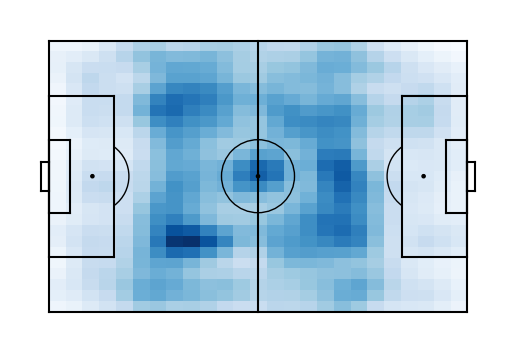

In [99]:
plot_starting_position_heatmap(df_actions[(df_actions['shot_in_next_10_actions']) & (df_actions['type_name'] == 'pass')])

In [ ]:
with pd.HDFStore('/spadl.h5') as spadlstore:
    for index, row in df_games():
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how="left")
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )


The following cell shows a widget which we can use to easily explore the actions in our dataset.

In [ ]:
interact_manual(plot_actions_from_action_name,
                df_actions = fixed(df_actions),
                action_name=widgets.Select(
                    options = df_actions['action_name'][3:],
                    disabled=False)
               )


# Representing actions

In this section we will create features that describe the action. We will take one action as an example. Every action has several characteristics, these include:
* start location
* end location
* action type
* bodypart used
* result (successful or not)
* time in the match

In [ ]:
action_id = 145
plot_actions(df_actions[action_id:action_id+1])

In [ ]:
df_actions[action_id:action_id+1].T

## Representing locations

We will first take a look at how we can represent locations. We first define the pitch sizes as used in the SPADL representation. A very interesting blog post by the KU Leuven on the interplay between features and models in football can be found here: https://dtai.cs.kuleuven.be/sports/blog/illustrating-the-interplay-between-features-and-models-in-xg.

In [ ]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

In [ ]:
df_actions[action_id:action_id+1][['start_x', 'start_y', 'end_x', 'end_y']]

The following cell adds columns to the actions dataframe with the normalized start and end coordinates of the actions.

In [ ]:
for side in ['start', 'end']:
    # Normalize the X location
    key_x = f'{side}_x'
    df_actions[f'{key_x}_norm'] = df_actions[key_x] / PITCH_LENGTH

    # Normalize the Y location
    key_y = f'{side}_y'
    df_actions[f'{key_y}_norm'] = df_actions[key_y] / PITCH_WIDTH

In [ ]:
df_actions[action_id:action_id+1][['start_x_norm', 'start_y_norm', 'end_x_norm', 'end_y_norm']]

The following cells compute the polar coordinates of the start and end location of the actions.

In [ ]:
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

In [ ]:
for side in ['start', 'end']:
    diff_x = GOAL_X - df_actions[f'{side}_x']
    diff_y = abs(GOAL_Y - df_actions[f'{side}_y'])
    df_actions[f'{side}_distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    df_actions[f'{side}_angle_to_goal'] = np.divide(diff_x, diff_y,
                                                    out=np.zeros_like(diff_x),
                                                    where=(diff_y != 0))

In [ ]:
df_actions[action_id:action_id+1][['start_distance_to_goal', 'start_angle_to_goal', 'end_distance_to_goal', 'end_angle_to_goal']]

The following cell adds a column indicating whether the action starts and/or ends in the opponent penalty box.

*Exercise*: think of more features describing the start and end location of the action.

In [ ]:
for side in ['start', 'end']:
    df_actions[f'{side}_is_penalty_box'] = ((df_actions[f'{side}_x'] > (PITCH_LENGTH-16.5)) &
                                            (df_actions[f'{side}_y'] > (13.85)) &
                                            (df_actions[f'{side}_y'] > (PITCH_WIDTH-13.85)))

In [ ]:
df_actions[action_id:action_id+1][['start_is_penalty_box', 'end_is_penalty_box']]

## Representing body part, action type and result

The following cells inspect the type_name, bodypart_name and result_name columns.

In [ ]:
pd.get_dummies(df_actions['type_name'])

In [ ]:
def add_action_type_dummies(df_actions):
    return df_actions.merge(pd.get_dummies(df_actions['type_name']), how='left',
                             left_index=True, right_index=True)

In [ ]:
df_actions = add_action_type_dummies(df_actions)

In [ ]:
df_actions[action_id:action_id+1]

In [ ]:
df_actions['bodypart_name'].unique()

In [ ]:
df_actions['result_name'].unique()

In [ ]:
df_actions[action_id:action_id+1][['bodypart_name', 'result_name']]

## Determine distance covered in x, y and total time played

The following cells define functions that add distance features and the actual time played in the match at the moment of the action.

In [ ]:
def add_distance_features(df_actions):
    df_actions['diff_x'] = df_actions['end_x'] - df_actions['start_x']
    df_actions['diff_y'] = df_actions['end_y'] - df_actions['start_y']
    df_actions['distance_covered'] = np.sqrt((df_actions['end_x'] - df_actions['start_x']) ** 2 +
                                             (df_actions['end_y'] - df_actions['start_y']) ** 2)

In [ ]:
def add_time_played(df_actions):
    df_actions['time_played'] = (df_actions['time_seconds'] +
                             (df_actions['period_id'] >= 2) * (45 * 60) +
                             (df_actions['period_id'] >= 3) * (15 * 60) +
                             (df_actions['period_id'] == 4) * (15 * 60)
                             )

In [ ]:
add_distance_features(df_actions)
add_time_played(df_actions)

In [ ]:
df_actions[action_id:action_id+1][['diff_x', 'diff_y', 'distance_covered', 'time_played']]

# Representing game states

As a game state is more than just the previous action, we want to add more information on the sequence leading up to the action. This includes information on the previous actions, but also more contextual features like the score and time in the match.

## Representing actions leading to game state

In the \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" paper we take the three actions leading to the game state into account. We investigated how many actions we should include and got the best results for three actions back.

*Exercise:* you could try out different numbers of actions to include in the game state and analyze the results.

Let's first take a look at the action again and what happened before the action was executed.

In [ ]:
for i in range(3):
    df_actions_to_plot = df_actions[145-i:146]
    plot_actions(df_actions_to_plot)

The following cells add extra columns for each action on the x actions before the action itself. You can define how far back you want to go and what features to take into account for all actions.

In [ ]:
delays = 3  # you can play around with this number
features_to_delay = ['game_id', 'period_id', 'time_seconds', 'team_id',
                     'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                     'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                     'time_played']

In [ ]:
def create_delayed_features(df_actions, features_to_delay, delays):
    df_delays = [df_actions[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0, delays)]
    return pd.concat(df_delays, axis=1)

In [ ]:
df_features = create_delayed_features(df_actions, features_to_delay, delays)

In [ ]:
location_cols = [f'{side}_{xy}-{delay}' for delay in reversed(range(0, delays))
                 for xy in ['x', 'y'] for side in ['start', 'end']]
df_features[action_id:action_id+1][location_cols]

In [ ]:
cols = [f'{col}-{delay}' for delay in reversed(range(0, delays))
        for col in ['period_id', 'time_seconds', 'type_name', 'bodypart_name', 'result_name']]
df_features[action_id:action_id+1][cols]

We need to invert the coordinates for the actions made by the other team to make sure all features represent the same thing. Therefore we add an indicator for the delayed actions to indicate whether the action was executed by the same team or not. If not then we need to invert the coordinates as the coordinates normally always go from left to right for the team in possession.

In [ ]:
def add_same_team(df_features, delays):
    for step in range(1, delays):
        df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

In [ ]:
add_same_team(df_features, delays)

In [ ]:
def invert_coordinates(df_features, delays):
    for step in range(1, delays):
        for side in ['start', 'end']:
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_x-{step}'] = PITCH_LENGTH - df_features[f'{side}_x-{step}']
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_y-{step}'] = PITCH_WIDTH - df_features[f'{side}_y-{step}']

In [ ]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

In [ ]:
invert_coordinates(df_features, delays)

In [ ]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

The following cells add the location featues for all actions and their delayed actions using the right coordinates.

In [ ]:
def add_location_features(df_features, delays):
    for step in range(0, delays):
        for side in ['start', 'end']:
            # Normalize the X location
            key_x = f'{side}_x'
            df_features[f'{key_x}_norm-{step}'] = df_features[f'{key_x}-{step}'] / PITCH_LENGTH

            # Normalize the Y location
            key_y = f'{side}_y'
            df_features[f'{key_y}_norm-{step}'] = df_features[f'{key_y}-{step}'] / PITCH_WIDTH

            diff_x = GOAL_X - df_features[f'{side}_x-{step}']
            diff_y = abs(GOAL_Y - df_features[f'{side}_y-{step}'])
            df_features[f'{side}_distance_to_goal-{step}'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
            df_features[f'{side}_angle_to_goal-{step}'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))

            df_features[f'diff_x-{step}'] = df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']
            df_features[f'diff_y-{step}'] = df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']
            df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']) ** 2 +
                                             (df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']) ** 2)

In [ ]:
add_location_features(df_features, delays)

In [ ]:
df_features.head()

## Adding contextual features

We also want to add some additional context to the game state. For example the speed of play, the time in the match and the current score in the match might influence the value of the game state.

*Exercise:* think of extra features that might influence the value of a game state.

## Sequence features

The following cells add extra context on the sequence. The distance covered in x and y direction as well as the time passed in the sequence are added to the dataframe. These features might tell the model something about the speed of play, whether the game quickly progressed from one side to another (probably indicating a counter attack) or whether it is a slow build up play.

In [ ]:
def add_sequence_pre_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_pre'] = df_features['start_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_pre'] = df_features['start_y-0'] - df_features[f'start_y-{delay}']
    df_features['time_sequence_pre'] = df_features['time_played-0'] - df_features[f'time_played-{delay}']

In [ ]:
add_sequence_pre_features(df_features, delays)

In [ ]:
def add_sequence_post_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_post'] = df_features['end_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_post'] = df_features['end_y-0'] - df_features[f'start_y-{delay}']

In [ ]:
add_sequence_post_features(df_features, delays)

In [ ]:
df_features[action_id:action_id+1]

# Generate features for a match

The following cell defines a function that creates all features described above for a dataframe of actions for a given match.

In [ ]:
def create_features_match(df_actions, features_to_delay, delays):
    df_action_features = add_action_type_dummies(df_actions)
    add_time_played(df_action_features)
    df_gamestate_features = create_delayed_features(df_action_features, features_to_delay, delays)
    add_same_team(df_gamestate_features, delays)
    invert_coordinates(df_gamestate_features, delays)
    add_location_features(df_gamestate_features, delays)
    add_sequence_pre_features(df_gamestate_features, delays)
    add_sequence_post_features(df_gamestate_features, delays)
    return df_gamestate_features

# Generate labels for a match

The following cells define two functions that compute the labels of our two machine learning tasks. The first one tells us whether a goal was scored within x actions, whereas the second function tells us whether a goal was conceded within the next x actions.

*Exercise*: play around with the number of actions to look ahead. In our paper we look 10 actions ahead.

In [ ]:
def label_scores(df_actions, nr_actions):
    """
    This functiondf_actions determines whether a goal was scored by the team possessing
    the ball within the next x actions
    """
    # merging goals, owngoals and team_ids

    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    scores = y['goal']
    for i in range(1, nr_actions):
        goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        own_goal_opponent = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        scores = scores | goal_scored | own_goal_opponent

    return pd.DataFrame(scores, columns=['scores'])

In [ ]:
def label_concedes(df_actions, nr_actions):
    """
    This function determines whether a goal was scored by the team not
    possessing the ball within the next x actions
    """
    # merging goals,owngoals and team_ids
    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    concedes = y['owngoal']
    for i in range(1, nr_actions):
        goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        own_goal_team = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        concedes = concedes | goal_opponent | own_goal_team

    return pd.DataFrame(concedes, columns=['concedes'])

We compute the labels for the match and investigate the labels for the last ten actions in the match.

In [ ]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10),
                           label_concedes(df_actions, nr_actions=10)],
                          axis=1)

In [ ]:
df_labels.tail(10)

In [ ]:
pd.merge(df_actions[['team_name', 'short_name', 'type_name']],
         df_labels,
         left_index=True,
         right_index=True).tail(10)

# Generate features and labels for all matches

The following cells generate and store the features and labels for all matches in your spadl.h5 file. This might take some minutes.

In [ ]:
df_games = pd.read_hdf('spadl.h5', key='games')

In [ ]:
df_games.head()

In [ ]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .reset_index(drop=True)
        )

    df_features = create_features_match(df_actions, features_to_delay, delays)
    df_features.to_hdf('features.h5', f'game_{game_id}')

    df_labels = pd.concat([label_scores(df_actions, nr_actions=10),
                           label_concedes(df_actions, nr_actions=10)],
                          axis=1)
    df_labels.to_hdf('labels.h5', f'game_{game_id}')